In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sparse_ir

In [2]:
t = 1 # means the bandwidth W is W=8t in a square lattice model
beta = 50 # inverse temperature
nk = 36 # number of k-points for a signle-axis
b_eff = 3 # strength of the effective magnetic field

In [3]:
class liechtenstein:
  def __init__(self, basis, *args):
    # constructor of liechtenstein class
    # the class requires five arguments: sparse_ir basis object, t, beta, nk, and b_eff
    
    self.basis, self.M, self.T = basis, sparse_ir.MatsubaraSampling(basis), sparse_ir.TauSampling(basis)
    t, self.beta, self.nk, self.b_eff= args[0], args[1], args[2], args[3]
    k1, k2 = np.meshgrid(np.arange(self.nk)/self.nk, np.arange(self.nk)/self.nk, indexing='ij')
    self.ek = -2* t * (np.cos(2*np.pi*k1) + np.cos(2*np.pi*k2))
    self.nkt = self.nk**2

  def j0_calc(self, e_range=np.zeros(1), NM=None):
    # solver to evaluate J_0
    # e_range: numpy ndarray object to specify the chemical potentials at which we evaluate J_0
    # NM: maximum number of Matsubara frequency. if None, sparse sampling will be used
  
    # set Matsubara frequency grid
    if NM is None: iw = 1j*np.pi*self.M.sampling_points/self.beta
    else         : iw = 1j*np.pi*(2*np.arange(-NM,NM)+1)/self.beta

    # calculate the first term in the expresson of J_0
    n_up = .5 * (1-np.tanh(.5*self.beta*(self.ek[None,:,:]-e_range[:,None,None]-self.b_eff)))
    n_dn = .5 * (1-np.tanh(.5*self.beta*(self.ek[None,:,:]-e_range[:,None,None]+self.b_eff)))
    j0_1 = .5 * self.b_eff * np.mean(n_up - n_dn, axis=(1,2))
        
    # calculate the second term in the expression of J_0 as a function of iw 
    gkio_up = 1/(iw[:,None,None,None] - (self.ek[None,None,:,:]-self.b_eff-e_range[None,:,None,None]))
    gkio_dn = 1/(iw[:,None,None,None] - (self.ek[None,None,:,:]+self.b_eff-e_range[None,:,None,None]))
    gio_up = np.mean(gkio_up, axis=(2,3))
    gio_dn = np.mean(gkio_dn, axis=(2,3))
    j0_2_w = self.b_eff**2 * gio_up * gio_dn
    
    # evaluate a summation over iw 
    if NM is None:
      j0_2_l = self.M.fit(j0_2_w.reshape(len(iw),len(e_range))) # transform to the intermediate representation
      j0_2 = self.basis.u(0)@j0_2_l # evaluate the function at \tau=0
    else:
      j0_2 = np.sum(j0_2_w,axis=0)/self.beta
    
    # sum up the two terms
    self.j0 = np.real(j0_1 + j0_2)
    self.j0_e_range = e_range

  def jij_calc(self, mu=0, NM=None):
    # solver to evaluate J_ij
    # mu: the chemical potential at which we evaluate J_ij
    # NM: maximum number of Matsubara frequency. if None, sparse sampling will be used
    
    # set Matsubara frequency grid
    if NM is None: iw = 1j*np.pi*self.M.sampling_points/self.beta
    else         : iw = 1j*np.pi*(2*np.arange(-NM,NM)+1)/self.beta
        
    # calculate J_ij as a function of iw 
    gkio_up = 1/(iw[:,None,None] - (self.ek[None,:,:]-self.b_eff-mu))
    gkio_dn = 1/(iw[:,None,None] - (self.ek[None,:,:]+self.b_eff-mu))
    grio_up = np.fft.fftn(gkio_up,axes=(1,2))/self.nkt
    grio_dn = np.fft.ifftn(gkio_dn,axes=(1,2))
    jij_w = - self.b_eff**2 * grio_up * grio_dn
    
    # evaluate a summation of J_ij over iw 
    if NM is None:
      jij_l = self.M.fit(jij_w.reshape(len(iw),self.nkt))
      jij = self.basis.u(0)@jij_l
    else:
      jij = np.sum(jij_w,axis=0)/self.beta
    
    # arrange the format to ouput the data
    self.jij = np.real(jij)
    self.jij[0] = 0
    self.jij_r = np.linalg.norm(np.array(np.meshgrid(np.arange(self.nk),np.arange(self.nk), indexing='ij')), axis=0).flatten()

In [4]:
Lambda = 2*max(8*t, b_eff) * beta
basis = sparse_ir.FiniteTempBasis(statistics='F', beta=beta, wmax=Lambda, eps=1e-7)
l = liechtenstein(basis, t, beta, nk, b_eff)

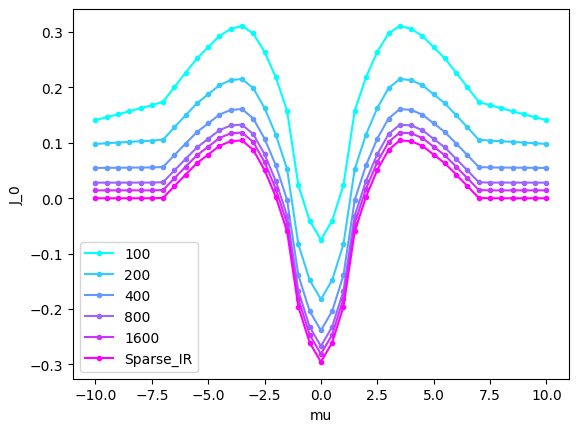

In [5]:
plt.xlabel("mu")
plt.ylabel("J_0")
for i, nm in enumerate([100, 200, 400, 800, 1600]):
      l.j0_calc(e_range=np.linspace(-10,10,41), NM=nm)
      plt.plot(l.j0_e_range, l.j0, marker='.', label=str(nm), color=cm.cool(i/5.))
l.j0_calc(e_range=np.linspace(-10,10,41))
plt.plot(l.j0_e_range, l.j0, marker='.', label='Sparse_IR', color=cm.cool(1.0))
plt.legend()
plt.show()

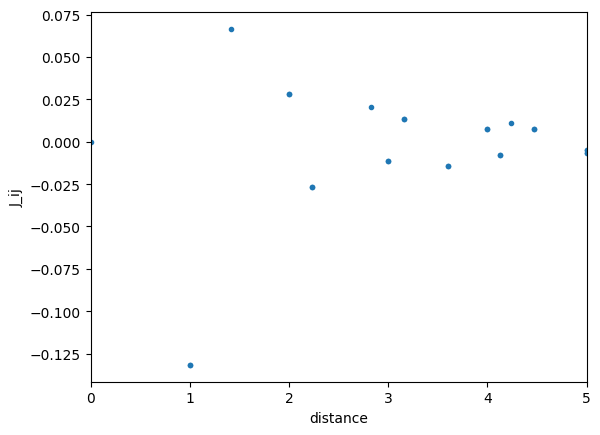

In [6]:
plt.clf
plt.xlabel("distance")
plt.ylabel("J_ij")
plt.xlim([0,5])
l.jij_calc(0)
plt.scatter(l.jij_r, l.jij, marker='.')
plt.show()

In [7]:
J0_1 = l.j0[20]   # J0 at mu=0 evaluated by j0_calc
J0_2 = sum(l.jij)  
print(J0_1,J0_2)

-0.2954591378323308

-0.2954591381253956